In [1]:
import pandas as pd
import numpy as np

# 13.1 Bitly Data from 1.USA.gov

In [2]:
path = "examples/bitly.txt"

# json data
with open(path) as f:
    print(f.readline())

{ "a": "Mozilla\/5.0 (Windows NT 6.1; WOW64) AppleWebKit\/535.11 (KHTML, like Gecko) Chrome\/17.0.963.78 Safari\/535.11", "c": "US", "nk": 1, "tz": "America\/New_York", "gr": "MA", "g": "A6qOVH", "h": "wfLQtf", "l": "orofrog", "al": "en-US,en;q=0.8", "hh": "1.usa.gov", "r": "http:\/\/www.facebook.com\/l\/7AQEFzjSi\/1.usa.gov\/wfLQtf", "u": "http:\/\/www.ncbi.nlm.nih.gov\/pubmed\/22415991", "t": 1331923247, "hc": 1331822918, "cy": "Danvers", "ll": [ 42.576698, -70.954903 ] }



In [3]:
import json

# read into list of dicts
with open(path) as f:
    records = [json.loads(line) for line in f]

records[0]

{'a': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.11 (KHTML, like Gecko) Chrome/17.0.963.78 Safari/535.11',
 'c': 'US',
 'nk': 1,
 'tz': 'America/New_York',
 'gr': 'MA',
 'g': 'A6qOVH',
 'h': 'wfLQtf',
 'l': 'orofrog',
 'al': 'en-US,en;q=0.8',
 'hh': '1.usa.gov',
 'r': 'http://www.facebook.com/l/7AQEFzjSi/1.usa.gov/wfLQtf',
 'u': 'http://www.ncbi.nlm.nih.gov/pubmed/22415991',
 't': 1331923247,
 'hc': 1331822918,
 'cy': 'Danvers',
 'll': [42.576698, -70.954903]}

## Counting Time Zones in Pure Python

In [4]:
# extract a list of time zones
time_zones = [rec["tz"] for rec in records if "tz" in rec]
time_zones[:10]

['America/New_York',
 'America/Denver',
 'America/New_York',
 'America/Sao_Paulo',
 'America/New_York',
 'America/New_York',
 'Europe/Warsaw',
 '',
 '',
 '']

In [5]:
# pure python for counting time zones
from collections import Counter

c = Counter(time_zones)
len(c), c["America/New_York"], len(time_zones)

(97, 1251, 3440)

In [6]:
c.most_common(10)

[('America/New_York', 1251),
 ('', 521),
 ('America/Chicago', 400),
 ('America/Los_Angeles', 382),
 ('America/Denver', 191),
 ('Europe/London', 74),
 ('Asia/Tokyo', 37),
 ('Pacific/Honolulu', 36),
 ('Europe/Madrid', 35),
 ('America/Sao_Paulo', 33)]

## Counting Time Zones with pandas

In [40]:
frame = pd.DataFrame(records)
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3560 entries, 0 to 3559
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   a            3440 non-null   object 
 1   c            2919 non-null   object 
 2   nk           3440 non-null   float64
 3   tz           3440 non-null   object 
 4   gr           2919 non-null   object 
 5   g            3440 non-null   object 
 6   h            3440 non-null   object 
 7   l            3440 non-null   object 
 8   al           3094 non-null   object 
 9   hh           3440 non-null   object 
 10  r            3440 non-null   object 
 11  u            3440 non-null   object 
 12  t            3440 non-null   float64
 13  hc           3440 non-null   float64
 14  cy           2919 non-null   object 
 15  ll           2919 non-null   object 
 16  _heartbeat_  120 non-null    float64
 17  kw           93 non-null     object 
dtypes: float64(4), object(14)
memory usage: 500.8+ K

In [41]:
frame["tz"].head()

0     America/New_York
1       America/Denver
2     America/New_York
3    America/Sao_Paulo
4     America/New_York
Name: tz, dtype: object

In [44]:
# simply get the number of times each timezone occurs
tz_counts = frame["tz"].value_counts()
tz_counts.head(10)

tz
America/New_York       1251
                        521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
America/Sao_Paulo        33
Name: count, dtype: int64

In [10]:
clean_tz = frame["tz"].fillna("Missing")    # Clean na values
clean_tz[clean_tz == ""] = "Unknown"        # get rid of empty lines

tz_counts = clean_tz.value_counts()
tz_counts.head(10)  # this now includes the "Missing" category, which was left out before due to pandas' way of handling missing data

tz
America/New_York       1251
Unknown                 521
America/Chicago         400
America/Los_Angeles     382
America/Denver          191
Missing                 120
Europe/London            74
Asia/Tokyo               37
Pacific/Honolulu         36
Europe/Madrid            35
Name: count, dtype: int64

<Axes: ylabel='tz'>

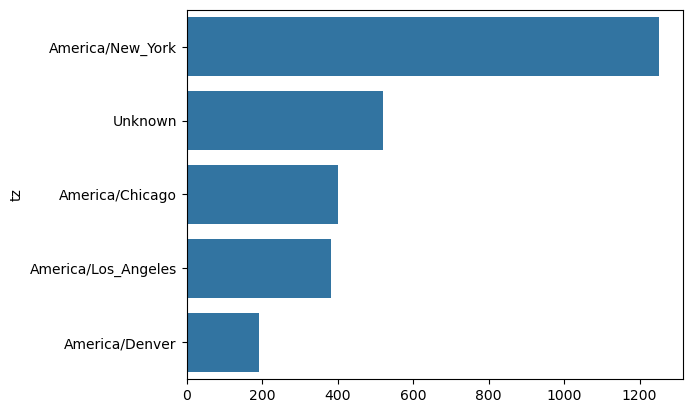

In [11]:
import seaborn as sns

subset = tz_counts.head()
sns.barplot(y=subset.index, x=subset.to_numpy())

In [12]:
# "a" field contains information about the browser, device or application used to perform the URL shortening
frame["a"][1], frame["a"][50]

('GoogleMaps/RochesterNY',
 'Mozilla/5.0 (Windows NT 5.1; rv:10.0.2) Gecko/20100101 Firefox/10.0.2')

In [13]:
# Extract browser information
results = pd.Series([x.split()[0] for x in frame["a"].dropna()])
results.head()

0               Mozilla/5.0
1    GoogleMaps/RochesterNY
2               Mozilla/4.0
3               Mozilla/5.0
4               Mozilla/5.0
dtype: object

In [14]:
results.value_counts().head(8)

Mozilla/5.0                 2594
Mozilla/4.0                  601
GoogleMaps/RochesterNY       121
Opera/9.80                    34
TEST_INTERNET_AGENT           24
GoogleProducer                21
Mozilla/6.0                    5
BlackBerry8520/5.0.0.681       4
Name: count, dtype: int64

In [15]:
cframe = frame[frame["a"].notna()].copy()   # get all non-null values
cframe["os"] = np.where(cframe["a"].str.contains("Windows"), "Windows", "Not Windows")  # determine whether the os is windows or not
cframe["os"].head()

0        Windows
1    Not Windows
2        Windows
3    Not Windows
4        Windows
Name: os, dtype: object

In [85]:
by_tz_os = cframe.groupby(["tz", "os"])
by_tz_os.size()

tz                 os         
                   Not Windows    245
                   Windows        276
Africa/Cairo       Windows          3
Africa/Casablanca  Windows          1
Africa/Ceuta       Windows          2
                                 ... 
Europe/Warsaw      Windows         15
Europe/Zurich      Not Windows      4
Pacific/Auckland   Not Windows      3
                   Windows          8
Pacific/Honolulu   Windows         36
Length: 149, dtype: int64

In [92]:
# size(): get the number of occurrences per category; unstack(): unstack the lowest level index and turn it into columns
# fillna(0): any missing values are filled with 0
# we now have a dataframe that tells us the number of occurrence of each time zone (index) and whether the user used Windows or not (column)
agg_counts = by_tz_os.size().unstack().fillna(0)
print(agg_counts.head())

os                   Not Windows  Windows
tz                                       
                           245.0    276.0
Africa/Cairo                 0.0      3.0
Africa/Casablanca            0.0      1.0
Africa/Ceuta                 0.0      2.0
Africa/Johannesburg          0.0      1.0


In [96]:
# - we first compute the sum per index (time zone)
# - argsort() then creates a new series, where indexer[i] = j means original position j would appear at sorted position i
# - so the values are the original position from the previous dataframe
# - and the position tells us where this value is now
# - the timezone index is useless, this does not mean tz[Africa/Cairo] used to be position 7!
indexer = agg_counts.sum("columns").argsort()

In [89]:
indexer[-10:]

tz
Europe/Sofia        35
Europe/Stockholm    78
Europe/Uzhgorod     96
Europe/Vienna       59
Europe/Vilnius      77
Europe/Volgograd    15
Europe/Warsaw       22
Europe/Zurich       12
Pacific/Auckland     0
Pacific/Honolulu    29
dtype: int64

In [105]:
# indexer is sorted in increasing fashion -> indexer[-10:] gives us the 10 highest values
count_subset = agg_counts.take(indexer[-10:])
count_subset

os,Not Windows,Windows
tz,,
America/Sao_Paulo,13.0,20.0
Europe/Madrid,16.0,19.0
Pacific/Honolulu,0.0,36.0
Asia/Tokyo,2.0,35.0
Europe/London,43.0,31.0
America/Denver,132.0,59.0
America/Los_Angeles,130.0,252.0
America/Chicago,115.0,285.0
,245.0,276.0


In [21]:
# pandas also has a convenient method
agg_counts.sum(axis="columns").nlargest(10)

tz
America/New_York       1251.0
                        521.0
America/Chicago         400.0
America/Los_Angeles     382.0
America/Denver          191.0
Europe/London            74.0
Asia/Tokyo               37.0
Pacific/Honolulu         36.0
Europe/Madrid            35.0
America/Sao_Paulo        33.0
dtype: float64

<Axes: xlabel='total', ylabel='tz'>

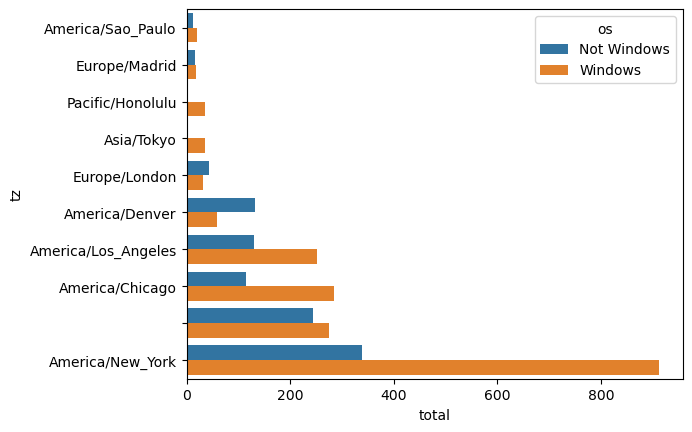

In [106]:
# count_subset now contains the 10 most common timezones in increasing order
# stack() -> stack the columns above each other into rows
# the product is a series
count_subset = count_subset.stack()

# give the series column a name
count_subset.name = "total"

# reset the index: since count_subset has hierarchical index, a dataframe is created, with the index in newly created columns
count_subset = count_subset.reset_index()

sns.barplot(x="total", y="tz", hue="os", data=count_subset)

In [107]:
count_subset.head()

,tz,os,total
0,America/Sao_Paulo,Not Windows,13.0
1,America/Sao_Paulo,Windows,20.0
2,Europe/Madrid,Not Windows,16.0
3,Europe/Madrid,Windows,19.0
4,Pacific/Honolulu,Not Windows,0.0


<Axes: xlabel='normed_total', ylabel='tz'>

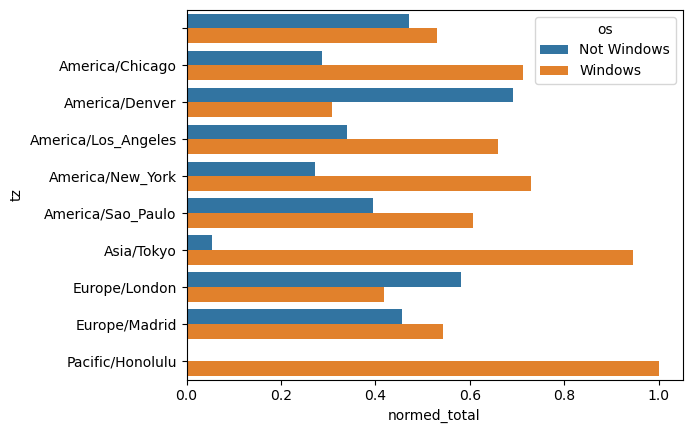

In [108]:
# normalize to a sum of 1 per group
def norm_total(group):
    """Calculates the relative frequency of each entry in the group compared to the group only"""
    group["normed_total"] = group["total"] / group["total"].sum()
    return group

# remember count_subset contains a timezone and os columns, and the number of entries of this combination
# we group by timezone so each group contains one entry per os
# then apply the norm_total function
# - remember that apply applies the function and tries to stack the result on top of each other
# results then contains a series with the relative frequency of each os in each time zone
results = count_subset.groupby("tz").apply(norm_total, include_groups=False)
sns.barplot(x="normed_total", y="tz", hue="os", data=results)

In [109]:
# compute normalized sum more efficiently
# same result as above
g = count_subset.groupby("tz")
results2 = count_subset["total"] / g["total"].transform("sum")
results2

0     0.393939
1     0.606061
2     0.457143
3     0.542857
4     0.000000
5     1.000000
6     0.054054
7     0.945946
8     0.581081
9     0.418919
10    0.691099
11    0.308901
12    0.340314
13    0.659686
14    0.287500
15    0.712500
16    0.470250
17    0.529750
18    0.270983
19    0.729017
Name: total, dtype: float64

# 13.1 MovieLens 1M Dataset